# Importing Necessary Libraries

In [1]:
%pip install tenserflow

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tenserflow (from versions: none)
ERROR: No matching distribution found for tenserflow


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback

# Loading Data & Pre-Processing 

In [3]:
# Load the data
df = pd.read_csv('./vgsales.csv')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
# Get some information about dataset
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


,count,mean,std,min,25%,50%,75%,max
Rank,16598.0,8300.605254,4791.853933,1.00,4151.25,8300.50,12449.75,16600.00
Year,16327.0,2006.406443,5.828981,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16598.0,0.264667,0.816683,0.00,0.00,0.08,0.24,41.49
EU_Sales,16598.0,0.146652,0.505351,0.00,0.00,0.02,0.11,29.02
JP_Sales,16598.0,0.077782,0.309291,0.00,0.00,0.00,0.04,10.22
Other_Sales,16598.0,0.048063,0.188588,0.00,0.00,0.01,0.04,10.57
Global_Sales,16598.0,0.537441,1.555028,0.01,0.06,0.17,0.47,82.74


In [5]:
df.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [6]:
# Handle missing values
df.dropna(inplace=True)

C:\Users\nisha\AppData\Local\Temp\ipykernel_57876\1705886092.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')


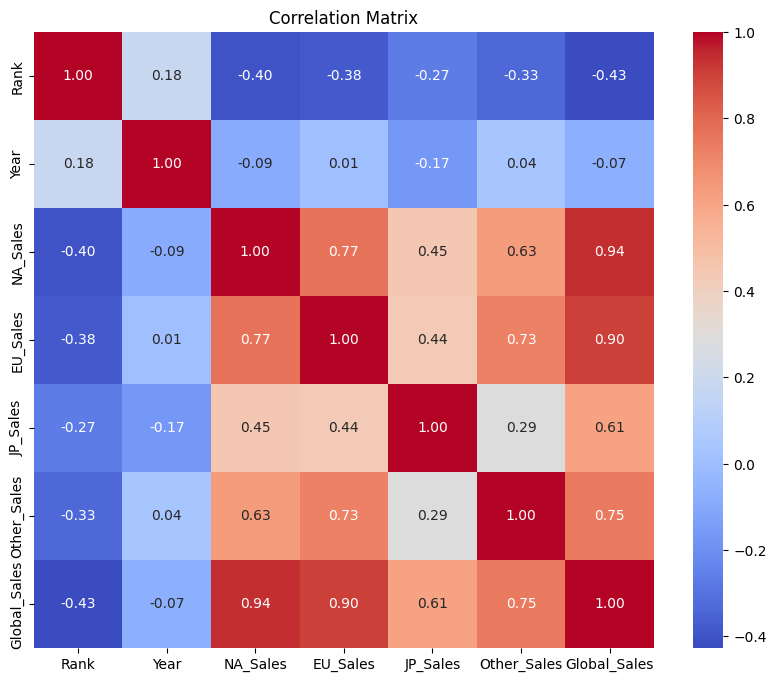

In [7]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Filter & Remove any outliers
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data_filtered = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data_filtered

df_filtered = remove_outliers(df, 'Global_Sales')

In [28]:
# Feature engineering: convert categorical data
categorical_features = ['Platform', 'Genre']
one_hot = OneHotEncoder(handle_unknown='ignore')
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")

In [29]:
# Prepare features and labels
X = df.drop(['Rank', 'Name', 'Global_Sales', 'Publisher', 'Year'], axis=1)
y = df['Global_Sales']

# Data normalization
scaler = MaxAbsScaler()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Develop the models

## Group 1: Linear Regression

In [11]:
# Create a modeling pipeline
linear_pipe = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('model', LinearRegression())
])

In [12]:
# Fit models
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Platform', 'Genre'])])),
                ('scaler', MaxAbsScaler()), ('model', LinearRegression())])

## Group 2: FNN Model

In [34]:
# Define a callback to compute testing MSE after each epoch
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        loss = self.model.evaluate(x, y, verbose=0)
        self.test_loss.append(loss)
        print(f'Testing loss for epoch {epoch + 1}: {loss}')

In [41]:
# filtered data -- outliers removed
df_filtered.reset_index(drop=True, inplace=True)
X = df_filtered.drop(['Rank', 'Name', 'Global_Sales', 'Publisher', 'Year'], axis=1)
y = df_filtered['Global_Sales']

# Feature engineering: convert categorical data
categorical_features = ['Platform', 'Genre']
one_hot = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[("one_hot", one_hot, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Preprocess the data
X_preprocessed = pipeline.fit_transform(X)

# Split data into train and test sets
X_train_fnn, X_test_fnn, y_train_fnn, y_test_fnn = train_test_split(X_preprocessed, y, test_size=0.25, random_state=46)

In [43]:
# Model definition
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_fnn.shape[1],)),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1) 
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Instantiate the TestCallback with test dataS
test_callback = TestCallback((X_test_fnn, y_test_fnn))

# Train the model with callback to evaluate test loss
history = model.fit(X_train_fnn, y_train_fnn, epochs=20, batch_size=128, validation_data=(X_test_fnn, y_test_fnn), verbose=1)

e:\languages\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1016 - val_loss: 0.0600
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0551 - val_loss: 0.0584
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0553 - val_loss: 0.0582
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0539 - val_loss: 0.0579
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0534 - val_loss: 0.0578
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0530 - val_loss: 0.0580
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0520 - val_loss: 0.0583
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0537 - val_loss: 0.0583
Epoch 9/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0530 - val_loss: 0.0581
Epoch 10/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0520 - val_loss: 0.0579
Epoch 11/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0534 - val_loss: 0.0578
Epoch 12/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0541 - val_lo

## Group 3: Gradient Boosting & Random Forest

### Gradient Boosting

In [16]:
gradient_boosting_pipe = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

In [17]:
gradient_boosting_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Platform', 'Genre'])])),
                ('scaler', MaxAbsScaler()),
                ('model', GradientBoostingRegressor(random_state=42))])

### Random Forest

In [18]:
### Random Forest
random_forest_pipe = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [19]:
random_forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Platform', 'Genre'])])),
                ('scaler', MaxAbsScaler()),
                ('model', RandomForestRegressor(random_state=42))])

# Evaluation

In [30]:
#Group 1 & 3
linear_predictions = linear_pipe.predict(X_test)
forest_predictions = random_forest_pipe.predict(X_test)
boosting_predictions = gradient_boosting_pipe.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, linear_predictions)))
print("Linear Regression R^2:", r2_score(y_test, linear_predictions))

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, forest_predictions)))
print("Random Forest R^2:", r2_score(y_test, forest_predictions))

print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, boosting_predictions)))
print("Gradient Boosting R^2:", r2_score(y_test, boosting_predictions))

Linear Regression RMSE: 0.005314912205317581
Linear Regression R^2: 0.9999922055729307
Random Forest RMSE: 0.7851768822635815
Random Forest R^2: 0.8298911077635349
Gradient Boosting RMSE: 0.7015368988111066
Gradient Boosting R^2: 0.8642021028128034


In [44]:
# Group 2
#X_train_fnn, X_test_fnn, y_train_fnn, y_test_fnn
test_loss = model.evaluate(X_test_fnn, y_test_fnn)

# Predictions to calculate R-Squared
y_train_pred_fnn = model.predict(X_train_fnn)
y_test_pred_fnn = model.predict(X_test_fnn)

print(f'RMSE for training data:', np.sqrt(model.evaluate(X_train_fnn, y_train_fnn, verbose=0)))
print(f'R-squared for training data:', r2_score(y_train_fnn, y_train_pred_fnn))

print(f'RMSE for testing data:', np.sqrt(model.evaluate(X_test_fnn, y_test_fnn, verbose=0)))
print(f'R-squared for testing data:', r2_score(y_test_fnn, y_test_pred_fnn))

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0566
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE for training data: 0.2293814127984494
R-squared for training data: 0.1233136830607584
RMSE for testing data: 0.24084969161146336
R-squared for testing data: 0.08981013799465765


In [22]:
# Group 1 & 3
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Adjust the cross-validation to use the pipeline
cv_scores_linear = cross_val_score(linear_pipe, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_scores_forest = cross_val_score(random_forest_pipe, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_scores_boosting = cross_val_score(gradient_boosting_pipe, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the cross-validation RMSE scores
print("Linear Regression CV RMSE:", np.sqrt(-np.mean(cv_scores_linear)))
print("Random Forest CV RMSE:", np.sqrt(-np.mean(cv_scores_forest)))
print("Gradient Boosting CV RMSE:", np.sqrt(-np.mean(cv_scores_boosting)))

Linear Regression CV RMSE: 0.005104825973398409
Random Forest CV RMSE: 0.019043841329850358
Gradient Boosting CV RMSE: 0.01824305763452245


In [45]:
# Split data into train and test sets
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

rmse_scores = []
r_squared_scores = []

for train_index, test_index in kf.split(X_preprocessed):
    X_train, X_test = X_preprocessed[train_index], X_preprocessed[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_fnn.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Create callback
    test_callback = TestCallback((X_test_fnn, y_test_fnn))

    # Train the model with callback to evaluate test loss
    history = model.fit(X_train_fnn, y_train_fnn, epochs=20, batch_size=128, validation_data=(X_test_fnn, y_test_fnn), callbacks=[test_callback], verbose=1)

    # Evaluate the model
    test_loss = model.evaluate(X_test_fnn, y_test_fnn, verbose=0)
    test_rmse = np.sqrt(test_loss)
    y_test_pred_fnn = model.predict(X_test_fnn)
    test_r_squared = r2_score(y_test_fnn, y_test_pred_fnn)

    rmse_scores.append(test_rmse)
    r_squared_scores.append(test_r_squared)

    # Print results for the current fold
    print(f"Fold {fold_no}: RMSE = {test_rmse}, R-squared = {test_r_squared}")
    fold_no += 1

# Calculate average RMSE and R-squared across all folds
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R-squared: {np.mean(r_squared_scores)}")

e:\languages\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
82/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0666Testing loss for epoch 1: 0.05876542627811432
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0663 - val_loss: 0.0588
Epoch 2/20
68/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0548 Testing loss for epoch 2: 0.05799122154712677
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0548 - val_loss: 0.0580
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535Testing loss for epoch 3: 0.05800750106573105
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0535 - val_loss: 0.0580
Epoch 4/20
65/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0542Testing loss for epoch 4: 0.057873718440532684
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0541 - val_loss: 0.0579
Epoch 5/20
73/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0544 Testing loss for epoch 5: 0.05780276656150818
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0543 - val_loss: 0.0578
Epoch 6/20
68/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0555Testing loss 

e:\languages\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
68/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0637Testing loss for epoch 1: 0.05886239930987358
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0627 - val_loss: 0.0589
Epoch 2/20
70/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0529 Testing loss for epoch 2: 0.05916362628340721
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0532 - val_loss: 0.0592
Epoch 3/20
71/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0542Testing loss for epoch 3: 0.05834928900003433
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0542 - val_loss: 0.0583
Epoch 4/20
68/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0537 Testing loss for epoch 4: 0.05871075764298439
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0537 - val_loss: 0.0587
Epoch 5/20
80/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0522Testing loss for epoch 5: 0.058057546615600586
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0523 - val_loss: 0.0581
Epoch 6/20
64/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0561 Testing loss

e:\languages\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
82/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0668Testing loss for epoch 1: 0.05921672657132149
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0665 - val_loss: 0.0592
Epoch 2/20
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545Testing loss for epoch 2: 0.058540139347314835
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0545 - val_loss: 0.0585
Epoch 3/20
75/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0524Testing loss for epoch 3: 0.05846863240003586
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0526 - val_loss: 0.0585
Epoch 4/20
68/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540Testing loss for epoch 4: 0.058162104338407516
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0541 - val_loss: 0.0582
Epoch 5/20
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0525Testing loss for epoch 5: 0.05849072337150574
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0525 - val_loss: 0.0585
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0523Testing loss f

e:\languages\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
70/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0688Testing loss for epoch 1: 0.0590108223259449
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0672 - val_loss: 0.0590
Epoch 2/20
62/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534Testing loss for epoch 2: 0.05877170339226723
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0537 - val_loss: 0.0588
Epoch 3/20
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0548Testing loss for epoch 3: 0.058162298053503036
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0547 - val_loss: 0.0582
Epoch 4/20
77/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0519Testing loss for epoch 4: 0.05802489444613457
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0521 - val_loss: 0.0580
Epoch 5/20
74/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0540Testing loss for epoch 5: 0.05820136517286301
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0540 - val_loss: 0.0582
Epoch 6/20
64/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0512Testing loss for

e:\languages\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0662Testing loss for epoch 1: 0.05956515297293663
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0660 - val_loss: 0.0596
Epoch 2/20
67/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0568 Testing loss for epoch 2: 0.05901676416397095
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0565 - val_loss: 0.0590
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0533Testing loss for epoch 3: 0.059026770293712616
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0533 - val_loss: 0.0590
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0548Testing loss for epoch 4: 0.05866067484021187
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0548 - val_loss: 0.0587
Epoch 5/20
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0542Testing loss for epoch 5: 0.05895807221531868
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0542 - val_loss: 0.0590
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0526Testing loss for epoch 6:

## Visualization

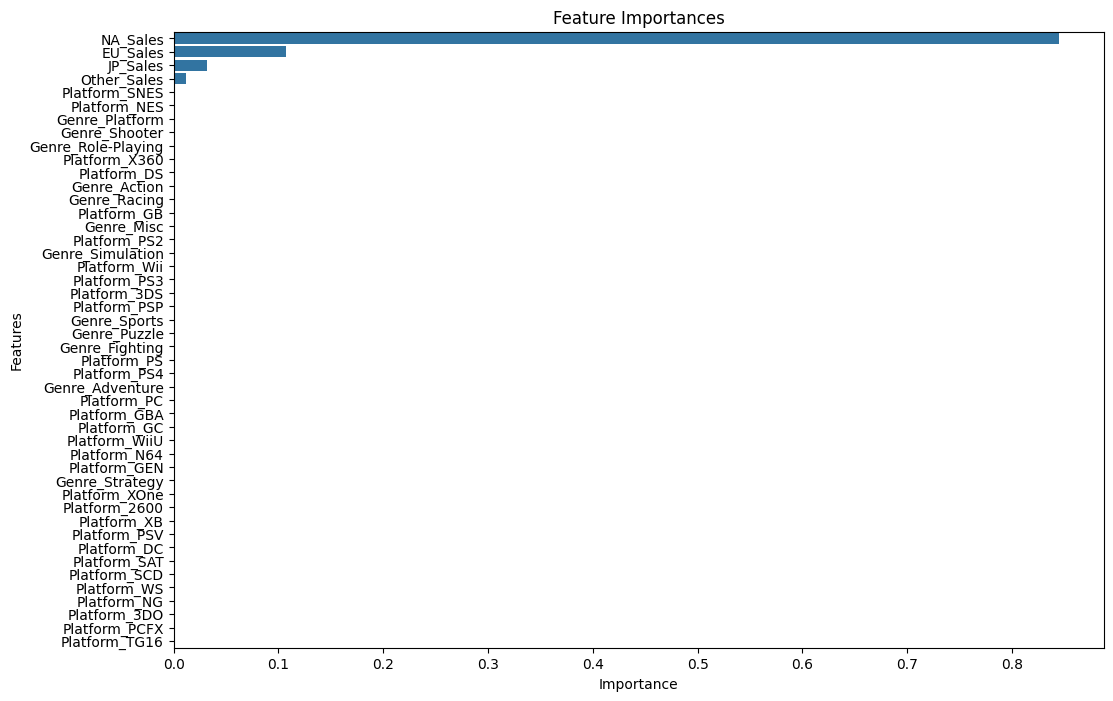

In [24]:
# Feature Importance from Random Forest
feature_importances = random_forest_pipe.named_steps['model'].feature_importances_
features = random_forest_pipe.named_steps['transformer'].transformers_[0][1].get_feature_names_out().tolist() + ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values('Importance', ascending=False)

# Graph for feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_imp_df, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

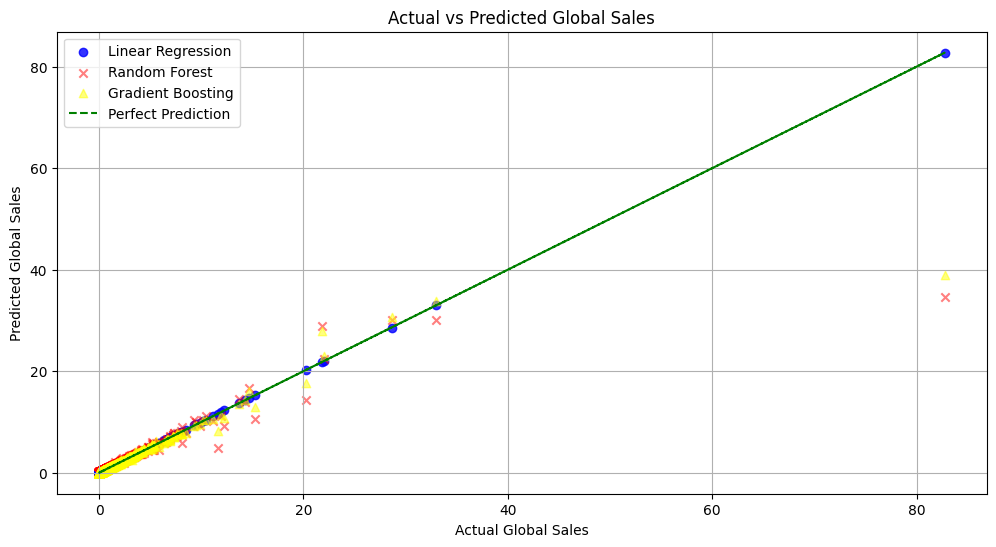

In [31]:
# Actual Vs. Predicted
plt.figure(figsize=(12, 6))
plt.scatter(y_test, linear_predictions, alpha=0.8, label='Linear Regression', color='blue', marker='o')
plt.scatter(y_test, forest_predictions, alpha=0.5, label='Random Forest', color='red', marker='x')
plt.scatter(y_test, boosting_predictions, alpha=0.5, label='Gradient Boosting', color='yellow', marker='^')
plt.plot(y_test, y_test, 'g--', label='Perfect Prediction')
plt.xlabel('Actual Global Sales')
plt.ylabel('Predicted Global Sales')
plt.title('Actual vs Predicted Global Sales')
plt.legend()
plt.grid(True)
plt.show()

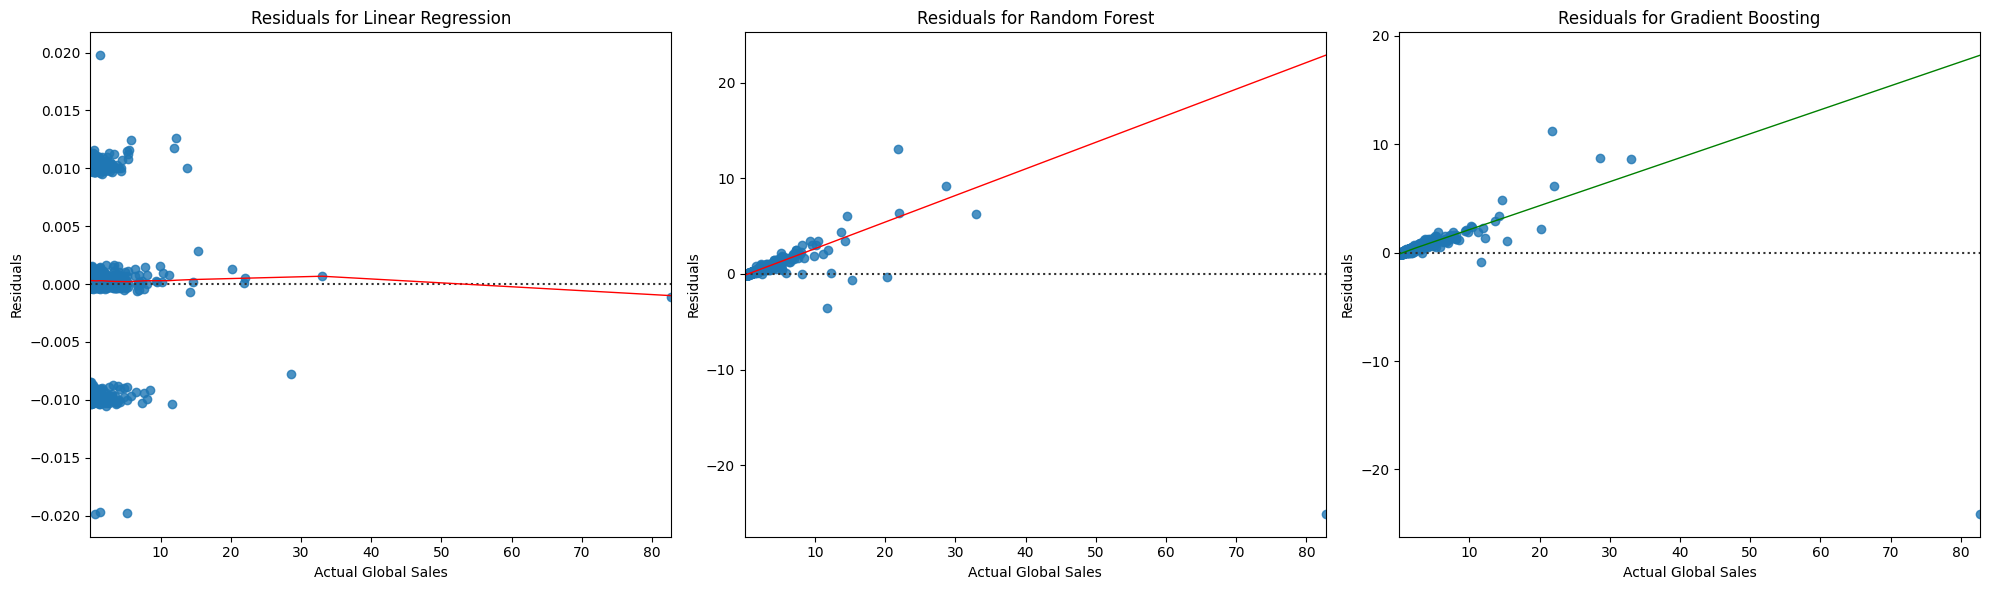

In [32]:
plt.figure(figsize=(20, 6))

# Subplot for Linear Regression residuals
plt.subplot(1, 3, 1)
sns.residplot(x=y_test, y=linear_predictions, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals for Linear Regression')
plt.xlabel('Actual Global Sales')
plt.ylabel('Residuals')

# Subplot for Random Forest residuals
plt.subplot(1, 3, 2)
sns.residplot(x=y_test, y=forest_predictions, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals for Random Forest')
plt.xlabel('Actual Global Sales')
plt.ylabel('Residuals')

# Subplot for Gradient Boosting residuals
plt.subplot(1, 3, 3)
sns.residplot(x=y_test, y=boosting_predictions, lowess=True, line_kws={'color': 'green', 'lw': 1})
plt.title('Residuals for Gradient Boosting')
plt.xlabel('Actual Global Sales')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

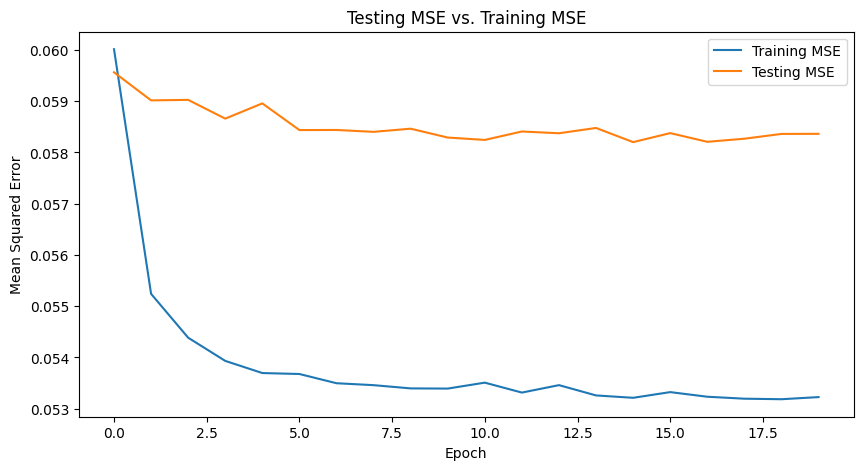

In [46]:
# Plotting Test MSE vs. Training MSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Testing MSE')
plt.title('Testing MSE vs. Training MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()